In [1]:
import networkx as nx
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

from API import K
import requests
import json
import googlemaps
from dms2dec.dms_convert import dms2dec
import geopy.distance

## Import network and IVS data

In [2]:
# import network
G = pickle.load(open('data/network_digital_twin_v0.3.pickle', 'rb'))

# import cleaned and restructured IVS data
df_ivs = pickle.load( open("data/df_trips_per_path_hourly.p", "rb" ) )

df_h = pd.read_csv('data/cleaned_harbours.csv')
# extract position for drawing purposes
pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'],G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: G.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: G.degree[x])
df_nodes['degree'] = G.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])

In [3]:
df_ivs.replace(0,np.nan, inplace=True)
# for now only consider 100 most frequented origin destination pairs, may reconsider later
df_ivs = df_ivs.head(100)
# check dataframe
df_ivs

,origin,destination,trip_count,M12,M8,M9,BIIa-1,BII-6b,M10,BII-6l,...,C4,C2l,M0,B04,BII-2L,B02,C1b,C2b,B01,C1l
0,NLRTM,NLAMS,9943,2076.0,3510.0,1316.0,102.0,NaN,427.0,NaN,...,5.0,7.0,11.0,5.0,39.0,4.0,NaN,NaN,NaN,NaN
1,NLRTM,NLMOE,2686,70.0,1584.0,144.0,2.0,NaN,56.0,NaN,...,2.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NLRTM,NLVLI,2153,190.0,658.0,414.0,10.0,NaN,140.0,NaN,...,NaN,2.0,2.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN
3,NLAMS,NLAER,2119,6.0,132.0,NaN,2.0,NaN,7.0,NaN,...,NaN,1.0,5.0,37.0,NaN,3.0,NaN,1.0,1.0,NaN
5,NLVEG,NLRTM,1484,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,NLHTB,NLBON,324,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NLKGZ,NLZAA,319,NaN,NaN,NaN,211.0,NaN,NaN,NaN,...,NaN,NaN,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
103,NLRTM,NLLID,311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NLRTM,NLSLU,310,3.0,205.0,6.0,NaN,NaN,46.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 1: Select relevant harbours and determine decimal degrees coordinates for all habours

In [4]:
# get unique harbours from IVS dataframe
h_list = list(set(list(df_ivs.origin.unique())) | set(list(df_ivs.destination.unique())))

# get unique city codes (e.g. remove NL prefix)
h_list = [re.sub("NL", "", i) for i in h_list]

#subset harbour data for these harbours and reset index
df_h = df_h.loc[(df_h.city_abbr.isin(h_list)) & (df_h.country == 'NL')]
df_h.reset_index(inplace=True, drop=True)

In [5]:
len(h_list)

70

In [6]:
# fix dtypes
for i in df_h.columns:
    if df_h.dtypes[i] == 'O':
        df_h[i] = df_h[i].astype('|S80')
        df_h[i] = df_h[i].apply(lambda x: x.decode('utf-8'))
# the coordinates are inaccurate and quite a lot of data is missing. This must be fixed first before we continue.

In [7]:
# #convert latitude and longitude to decimal degrees for harbours with this entry
df_h['lat'] = 0
df_h['lon'] = 0
for key, coords in enumerate(df_h.coords):
    lat_lon=[]
    if coords!='nan':
        for j in range(2):
            if j == 0:
                part_a = coords.split()[j][:2]
                part_b = coords.split()[j][-3:-1]
                cor = (str(part_a)+"°"+str(part_b)+''''0"N"''')
                cor = dms2dec(cor)
                df_h.lat[key] = cor
            else:
                part_a = coords.split()[j][:3]
                part_b = coords.split()[j][-3:-1]
                cor = (str(part_a)+"°"+str(part_b)+''''0"E"''')
                cor = dms2dec(cor)
                df_h.lon[key] = cor

C:\Users\Fabia\AppData\Local\Temp\ipykernel_4108\427254228.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h.lat[key] = cor
C:\Users\Fabia\AppData\Local\Temp\ipykernel_4108\427254228.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h.lon[key] = cor


In [8]:
df_h

,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon
0,78676,NL,ABL,Alblasserdam,1-------,nan,NLABL,0.000000,0.000000
1,78678,NL,ALK,Alkmaar,123-----,5238N 00445E,NLALK,52.633333,4.750000
2,78680,NL,ALM,Almelo,123-----,5221N 00640E,NLALM,52.350000,6.666667
3,78682,NL,AER,Almere,1-3--6--,5222N 00513E,NLAER,52.366667,5.216667
4,78685,NL,APN,Alphen aan den Rijn,123-----,5208N 00440E,NLAPN,52.133333,4.666667
...,...,...,...,...,...,...,...,...,...
65,80378,NL,WTE,West-Terschelling,1-------,nan,NLWTE,0.000000,0.000000
66,80438,NL,WMO,Wormer,1-3-----,5230N 00449E,NLWMO,52.500000,4.816667
67,80450,NL,ZAA,Zaandam,123-----,nan,NLZAA,0.000000,0.000000
68,80514,NL,ZWI,Zwijndrecht,123-----,nan,NLZWI,0.000000,0.000000


In [9]:
# still missing quite some, try and fetch these using google maps api

### Try to retrieve missing data using google maps

In [10]:
for i, city in enumerate(df_h.city_full):
    if df_h.coords[i] == 'nan':
        r = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={'Haven', city, 'Nederland'}&key={K}")
        results = json.loads(r.content)
        if 'results' in results.keys():
            if len(results['results'])>0:
                lat_r = results['results'][0]['geometry']['location']['lat']
                lon_r = results['results'][0]['geometry']['location']['lng']
                df_h['lat'][i] = lat_r
                df_h['lon'][i] = lon_r
        else:
            print('No location found for harbour', city)


In [11]:
df_h.head(100)

,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon
0,78676,NL,ABL,Alblasserdam,1-------,nan,NLABL,51.861514,4.657490
1,78678,NL,ALK,Alkmaar,123-----,5238N 00445E,NLALK,52.633333,4.750000
2,78680,NL,ALM,Almelo,123-----,5221N 00640E,NLALM,52.350000,6.666667
3,78682,NL,AER,Almere,1-3--6--,5222N 00513E,NLAER,52.366667,5.216667
4,78685,NL,APN,Alphen aan den Rijn,123-----,5208N 00440E,NLAPN,52.133333,4.666667
...,...,...,...,...,...,...,...,...,...
65,80378,NL,WTE,West-Terschelling,1-------,nan,NLWTE,53.362705,5.216893
66,80438,NL,WMO,Wormer,1-3-----,5230N 00449E,NLWMO,52.500000,4.816667
67,80450,NL,ZAA,Zaandam,123-----,nan,NLZAA,52.442040,4.829199
68,80514,NL,ZWI,Zwijndrecht,123-----,nan,NLZWI,51.810598,4.627272


### Manually check and fill in last missing data

In [12]:
# some last manual changes
# Stein mistake google API fetch, finds somewhere near soest somehow
# Wageningen: location fetched at other side of the city
# Geertruidenberg: inland harbour instead of harbour along waal selected
# Genemuiden: inland harbour selected, might be problem because of curve in river around city
# Terneuzen: inland harbour selected somehow
# Farsum and Delfzijl: Delfzijl, mistake in coords, Farsum very closeby, safer to hard code
d_cor_h = {'Stein':[50.974662, 5.756552], 'Wageningen':[51.955027, 5.648670], 'Geertruidenberg': [51.712726, 4.845269], 'Genemuiden':[52.629176, 6.053162], 'Terneuzen':[51.342704, 3.814359], 'Farsum':[53.314251, 6.930846], 'Delfzijl':[53.330089, 6.934031]}

In [13]:
# fill in manually found values
for harbour in d_cor_h.keys():
    df_h.lat[df_h.loc[df_h.city_full == harbour].index] = d_cor_h[harbour][0]
    df_h.lon[df_h.loc[df_h.city_full == harbour].index] = d_cor_h[harbour][1]

C:\Users\Fabia\AppData\Local\Temp\ipykernel_4108\2124197816.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h.lon[df_h.loc[df_h.city_full == harbour].index] = d_cor_h[harbour][1]
C:\Users\Fabia\AppData\Local\Temp\ipykernel_4108\2124197816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h.lat[df_h.loc[df_h.city_full == harbour].index] = d_cor_h[harbour][0]
C:\Users\Fabia\AppData\Local\Temp\ipykernel_4108\2124197816.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

### Basic cleaning: apply bounding box en removing links from i to i

In [14]:
for node1, node2 in G.edges:
    if node1 == node2:
        print("Self loop identified node", node1)
        G.remove_edge(node1,node2)

Self loop identified node FN223
Self loop identified node FN432
Self loop identified node S46058_A
Self loop identified node S51275_A
Self loop identified node S16237927_A
Self loop identified node S48415_A
Self loop identified node S16240_A
Self loop identified node S24198_A
Self loop identified node S27425_A
Self loop identified node S28525_A
Self loop identified node S28525_B
Self loop identified node S56863_A
Self loop identified node S56863_B
Self loop identified node S57264_A


In [15]:
# bounding box nl
bb = (3.31497114423, 50.803721015, 7.09205325687, 53.5104033474)

df_nodes = df_nodes.loc[(df_nodes.X.between(bb[0], bb[2])) & (df_nodes.Y.between(bb[1], bb[3]))]

#visualise new subset

#subset graph and make editable again
G = G.subgraph(df_nodes.index)
G = nx.Graph(G)

### Visually check network and harbours

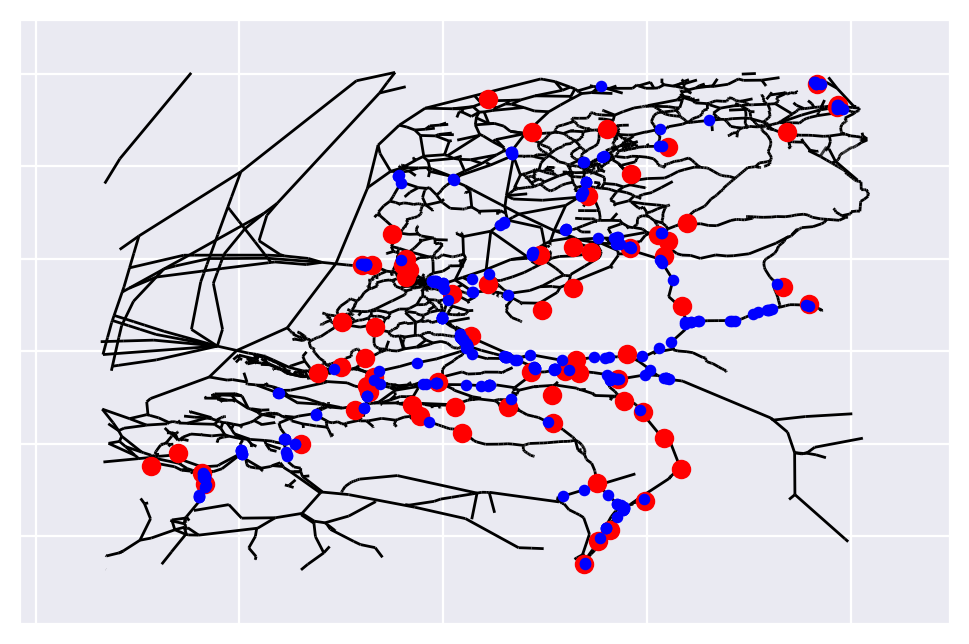

In [16]:
#visual check
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
plt.scatter(df_h.lon,df_h.lat,c='r')
a = df_h.loc[df_h.lon==df_h.lon.min()]
# plt.scatter(a.lon,a.lat,c='b')
berth_nodes = df_nodes.loc[df_nodes.n.str.contains('Berth')].index
berth_nodes = df_nodes.loc[df_nodes.index.isin(berth_nodes)]
plt.scatter(berth_nodes.X,berth_nodes.Y, s=10, c='b')

## Step 2: throw out all small nodes and only keep the largest component

In [17]:
#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [18]:
#check out codes to base selection on
df_links.Code.unique()
nodes_to_keep = list(df_links.loc[df_links.Code != '_0'].source) + list(df_links.loc[df_links.Code != '_0'].target)
G = G.subgraph(nodes_to_keep)
G = nx.Graph(G)

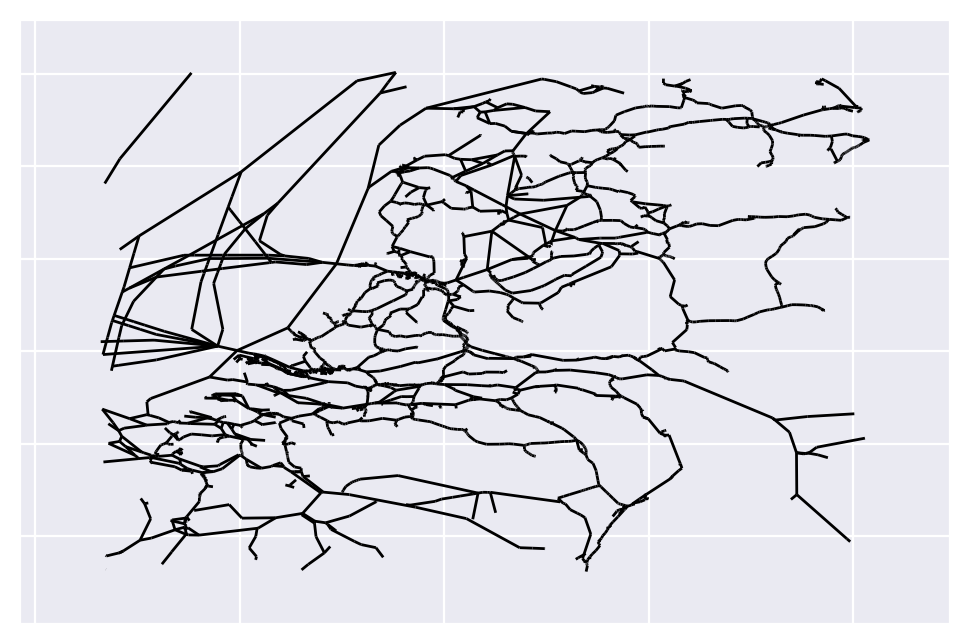

In [19]:
plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)

In [20]:
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

## Step 3: Determine harbour nodes
A harbour node, is a node on the ongoing route along which the harbour is located. This node may be found because of its degree which is higher than 3 and because the link of which it is the source node, has the tag vaarwegvak 0 tot H-0.

In [21]:
#Check initial range: 5k seems to be okay

In [22]:
dev = 0.04
a = 51.985103 + dev
b = 5.898730 + dev

In [23]:
geopy.distance.geodesic((51.985103,5.898730),(a,b))

Distance(5.230073271041756)

In [24]:
# create an additional column to put corresponding harbour node in
df_h['harbour_node'] = 0
# loop over all harbour entries
for i in df_h.index:
    x = df_h.lon[i]
    y = df_h.lat[i]
    dev = 0.04

    #find nodes within deviation
    #select nodes near
    selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev)) & (df_links.GeoType == 'section')&(df_links.source.str.isdigit())].index)

    # in some areas there are very few nodes, therefore iteratively increase range to look for nodes until at least one is found
    while len(selection) == 0:
        dev+=0.1
        selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev))].index)

    #select corresponding links and subset links that go to harbour, subset sections with origin is number (no object)
    selection = df_links.loc[((df_links.source.isin(selection))|(df_links.target.isin(selection)))&(df_links.Name == 'Vaarwegvak van 0 tot 0 - H')&(df_links.GeoType == 'section')&(df_links.source.str.isdigit())]

    if len(selection) != 0:
        selection['dist'] = 0
        # if there are items, take nearest, first we need to determine dists
        for j in selection.index:
            sel_source = selection.source[j]
            sel_source = df_nodes.loc[sel_source]
            selection.dist[j]=geopy.distance.geodesic((x,y),(sel_source.X,sel_source.Y))
        # sort by dist and pick firstG
        selection = selection.loc[selection.dist == selection.dist.min()].source
        df_h['harbour_node'][i]= selection.values[0]
    else:
        selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev))].index)
        if len(selection) != 0:
            selection = df_links.loc[((df_links.source.isin(selection))|(df_links.target.isin(selection)))&(df_links.GeoType == 'section')&(df_links.source.str.isdigit())]
            selection['dist'] = 0
            for j in selection.index:
                sel_source = selection.source[j]
                sel_source = df_nodes.loc[sel_source]
                selection.dist[j]=geopy.distance.geodesic((x,y),(sel_source.X,sel_source.Y))
            # sort by dist and pick firstG
            selection = selection.loc[selection.dist == selection.dist.min()].source
            df_h['harbour_node'][i]= selection.values[0]
        else:
            print('Check entry', df_h.city_full[i])

C:\Users\Fabia\AppData\Local\Temp\ipykernel_4108\1829627661.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection['dist'] = 0
C:\Users\Fabia\AppData\Local\Temp\ipykernel_4108\1829627661.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection.dist[j]=geopy.distance.geodesic((x,y),(sel_source.X,sel_source.Y))
C:\Users\Fabia\AppData\Local\Temp\ipykernel_4108\1829627661.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [25]:
harbour_nodes = list(df_h.harbour_node.unique())

In [26]:
harbour_nodes

['8866686',
 '8861625',
 '8866425',
 '8864005',
 '8863360',
 '8866763',
 '8863207',
 '8867083',
 '8868208',
 '8861528',
 '8865600',
 '8868222',
 '8867395',
 '8867429',
 '8862663',
 '8863518',
 '8867258',
 '8865412',
 '8866297',
 '8863614',
 '8866893',
 '8864018',
 '8863019',
 '8863861',
 '8865756',
 '8862085',
 '8863408',
 '22638320',
 '8864153',
 '8862497',
 '8868191',
 '8863260',
 '8866748',
 '8866564',
 '8863709',
 '8863125',
 '8861305',
 '8864954',
 '30984595',
 '8868423',
 '8867538',
 '8864494',
 '22638327',
 '8863818',
 '8862570',
 '8861718',
 '8863152',
 '8863306',
 '8866775',
 '8861462',
 '22638156',
 '8868266',
 '8863469',
 '22638146',
 '8867740',
 '8867240',
 '8865990',
 '8866671',
 '22637863',
 '8864111',
 '8866627',
 '8864566',
 '8864837',
 '8863966',
 '8865605',
 '8866889',
 '8865003',
 '8862506']

In [27]:
df_h

,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon,harbour_node
0,78676,NL,ABL,Alblasserdam,1-------,nan,NLABL,51.861514,4.657490,8866686
1,78678,NL,ALK,Alkmaar,123-----,5238N 00445E,NLALK,52.633333,4.750000,8861625
2,78680,NL,ALM,Almelo,123-----,5221N 00640E,NLALM,52.350000,6.666667,8866425
3,78682,NL,AER,Almere,1-3--6--,5222N 00513E,NLAER,52.366667,5.216667,8864005
4,78685,NL,APN,Alphen aan den Rijn,123-----,5208N 00440E,NLAPN,52.133333,4.666667,8863360
...,...,...,...,...,...,...,...,...,...,...
65,80378,NL,WTE,West-Terschelling,1-------,nan,NLWTE,53.362705,5.216893,8865605
66,80438,NL,WMO,Wormer,1-3-----,5230N 00449E,NLWMO,52.500000,4.816667,8866889
67,80450,NL,ZAA,Zaandam,123-----,nan,NLZAA,52.442040,4.829199,8866889
68,80514,NL,ZWI,Zwijndrecht,123-----,nan,NLZWI,51.810598,4.627272,8865003


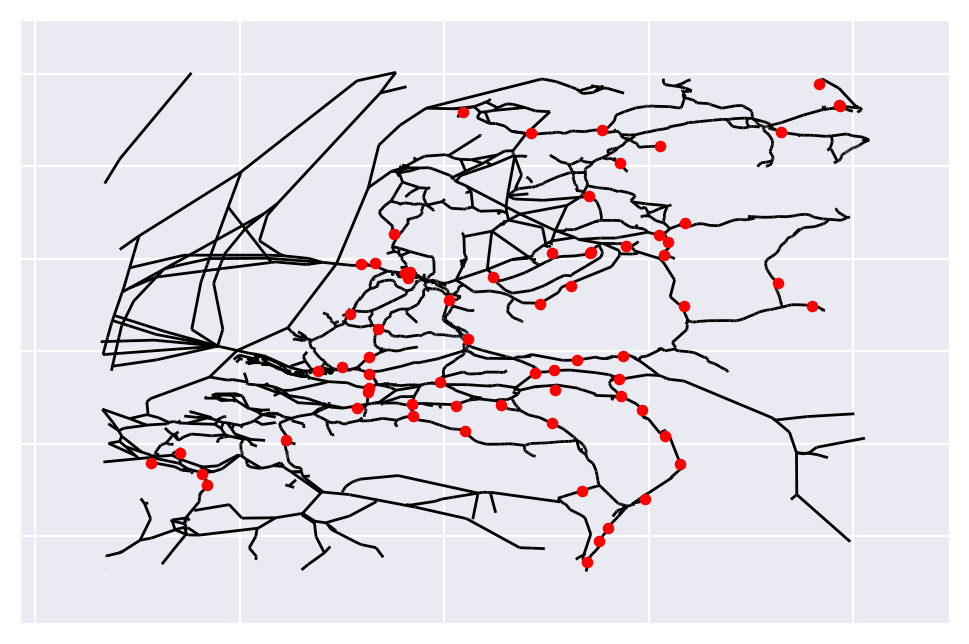

In [28]:
plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes,node_size=10, node_color='red')

## Step 4: Split flows where necessary
Large ships may not be able to take the same route as small ships, hence these should be observed as separate flows

In [29]:
types = list(df_links.Code.unique())
types.remove('_0')
types = sorted(types[1:])
print(types)
#sorted in wrong manner, correct manually
types = ['I', 'II', 'III', 'IV', 'V_A', 'V_B', 'VI_A', 'VI_B', 'VI_C']
type_dict={}
#minus 1 because last one is open class anyway
for i in range(len(types)-1):
    type_dict[i] = types[:(i+1)]
type_dict[8]=types

['I', 'II', 'III', 'IV', 'VI_A', 'VI_B', 'VI_C', 'V_A', 'V_B']


In [30]:
df_ivs

,origin,destination,trip_count,M12,M8,M9,BIIa-1,BII-6b,M10,BII-6l,...,C4,C2l,M0,B04,BII-2L,B02,C1b,C2b,B01,C1l
0,NLRTM,NLAMS,9943,2076.0,3510.0,1316.0,102.0,NaN,427.0,NaN,...,5.0,7.0,11.0,5.0,39.0,4.0,NaN,NaN,NaN,NaN
1,NLRTM,NLMOE,2686,70.0,1584.0,144.0,2.0,NaN,56.0,NaN,...,2.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NLRTM,NLVLI,2153,190.0,658.0,414.0,10.0,NaN,140.0,NaN,...,NaN,2.0,2.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN
3,NLAMS,NLAER,2119,6.0,132.0,NaN,2.0,NaN,7.0,NaN,...,NaN,1.0,5.0,37.0,NaN,3.0,NaN,1.0,1.0,NaN
5,NLVEG,NLRTM,1484,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,NLHTB,NLBON,324,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NLKGZ,NLZAA,319,NaN,NaN,NaN,211.0,NaN,NaN,NaN,...,NaN,NaN,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
103,NLRTM,NLLID,311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NLRTM,NLSLU,310,3.0,205.0,6.0,NaN,NaN,46.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
#To what extent to paths differ for these OD pairs for different boat types?
routes_dests = {}
routes_types_paths = {}
routes_types_path_lengths = {}
for i in df_ivs.index:

    org_n = df_ivs.origin[i]
    org = df_h.loc[df_h.harbour_code == org_n]['harbour_node'].values[0]
    dest_n = df_ivs.destination[i]
    dest = df_h.loc[df_h.harbour_code == dest_n]['harbour_node'].values[0]

    org_route = nx.dijkstra_path(G, org, dest, weight='length_m')
    routes_types_paths[(org_n, dest_n, 0)] = org_route
    routes_types_path_lengths[(org_n, dest_n, 0)] = nx.dijkstra_path_length(G, org, dest, weight='length_m')
    route_v = {0:types}
    r=0
    for type_index, types_exc in type_dict.items():

        #copy graph
        H = G.copy()

        #determine links that are not available based on dict (e.g. of the type in type_exc list)
        unavailable_edges = df_links.loc[df_links.Code.isin(types_exc)]
        #now remove those edges
        for link in unavailable_edges.index:
            H.remove_edge(unavailable_edges.source[link], unavailable_edges.target[link])

        if nx.has_path(H, org, dest):
            route_type = nx.dijkstra_path(H, org, dest, weight='length_m')
            if route_type != org_route:
                #new route found, r higher now
                r+=1
                #if first time alt: old route is for exc
                if r == 1:
                    route_v[r-1] = tuple(types_exc)
                #if not first time alt: previous route is for all as before minus ones that take new route
                else:
                    route_v[r-1] = tuple(set(route_v[r-1])-(set(types)-set(types_exc)))
                #new route is for all not excluded types
                route_v[r] = tuple(set(types)-set(types_exc))
                #store new route
                routes_types_paths[(org_n, dest_n, r)] = route_type
                routes_types_path_lengths[(org_n, dest_n, r)] = nx.dijkstra_path_length(H, org, dest, weight='length_m')

                #update most recent route
                org_route = route_type

                # print("Ships of type", set(types)-set(types_exc), "must take other route for path", org_n, dest_n)
    #add all routes to main dict to check
    routes_dests[(org_n,dest_n)] = route_v


In [5]:
routes_dests

{('NLRTM', 'NLAMS'): {0: ('I', 'II', 'III'),
  1: ('IV', 'V_A'),
  2: ('V_B', 'VI_B', 'VI_C', 'VI_A')},
 ('NLRTM', 'NLMOE'): {0: ('I', 'II', 'III', 'IV', 'V_A'),
  1: ('V_B', 'VI_B', 'VI_C', 'VI_A')},
 ('NLRTM',
  'NLVLI'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLAMS',
  'NLAER'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLVEG',
  'NLRTM'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLTLB', 'NLRTM'): {0: ('I',),
  1: ('VI_B', 'II', 'III', 'VI_A', 'V_B', 'IV', 'VI_C', 'V_A')},
 ('NLLEY',
  'NLAMS'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLOSS',
  'NLRTM'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLZWO',
  'NLAMS'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NL

In [33]:
routes_types_paths

{('NLRTM', 'NLAMS', 0): ['8863306',
  '8864009',
  '8866439',
  '8861193',
  'B4308_B',
  'B4308_A',
  '8861191',
  '8867588',
  '8863742',
  '8867374',
  'B4913_B',
  'B4913_A',
  'L24895_B',
  'L24895_A',
  '8864798',
  '8867538',
  '8867549',
  '8860860',
  '8868116',
  '8865170',
  '8866907',
  'B23943_B',
  'B23943_A',
  'L7804_B',
  'L7804_A',
  'B57545_B',
  'B57545_A',
  '8865214',
  'B32055_B',
  'B32055_A',
  'B18202_B',
  'B18202_A',
  'B51737_B',
  'B51737_A',
  'B17709784_B',
  'B17709784_A',
  'B19102_B',
  'B19102_A',
  'B46036_B',
  'B46036_A',
  '30985789',
  '8866363',
  'B46356_B',
  'B46356_A',
  'B26151_B',
  'S58510_A',
  'B26151_A',
  '8863360',
  'B26963_A',
  'B26963_B',
  'B3446_A',
  'B3446_B',
  'B41042_A',
  'B41042_B',
  'B33731_A',
  'B33731_B',
  '8862496',
  'B27700_B',
  'B27700_A',
  'S46906_B',
  'S46906_A',
  'B50163_B',
  'B50163_A',
  '8860982',
  '8867583',
  '8865263',
  '8865954',
  'S20232_B',
  'S20232_A',
  '8861413',
  '8862716',
  'S45168_

In [4]:
routes_dests = pickle.load(open('data/revised_cleaning_results/users_ship_specific_routes.p', 'rb'))

In [34]:
len(routes_types_paths.keys())

163

In [8]:
#create dict with cumulative rows that are related to each ship type
df_ships = pd.read_excel('data/ship_types.xlsx')

In [9]:
#pregenerate ship sets for combinations on routes
all_type_comb = []
for i in routes_dests.keys():
    for key, item in routes_dests[i].items():
        if not item in all_type_comb:
            all_type_comb.append(item)

In [10]:
cor_RWS_types = {}
for type_combi in all_type_comb:
    a = df_ships.loc[df_ships['CEMT-class'].isin(type_combi)]
    a = list(a['RWS-class'].values)
    cor_RWS_types[tuple(type_combi)] = a

In [11]:
cor_RWS_types
# looks good, now all that's left is to create the exploded df

{('I', 'II', 'III'): ['M1',
  'M2',
  'M3',
  'M4',
  'M5',
  'C1b',
  'C1l',
  'B01',
  'B02',
  'B04'],
 ('IV', 'V_A'): ['M6',
  'M7',
  'M8',
  'M9',
  'C2l',
  'BI',
  'BII-1',
  'BIIa-1',
  'BIIL-1'],
 ('V_B', 'VI_B', 'VI_C', 'VI_A'): ['M10',
  'M11',
  'M12',
  'C3l',
  'C2b',
  'C3b',
  'C4',
  'BII-2L',
  'BII-2b',
  'BII-4',
  'BII-6b',
  'BII-6l'],
 ('I', 'II', 'III', 'IV', 'V_A'): ['M1',
  'M2',
  'M3',
  'M4',
  'M5',
  'M6',
  'M7',
  'M8',
  'M9',
  'C1b',
  'C1l',
  'C2l',
  'B01',
  'B02',
  'B04',
  'BI',
  'BII-1',
  'BIIa-1',
  'BIIL-1'],
 ('I', 'II', 'III', 'IV', 'V_A', 'V_B', 'VI_A', 'VI_B', 'VI_C'): ['M1',
  'M2',
  'M3',
  'M4',
  'M5',
  'M6',
  'M7',
  'M8',
  'M9',
  'M10',
  'M11',
  'M12',
  'C1b',
  'C1l',
  'C2l',
  'C3l',
  'C2b',
  'C3b',
  'C4',
  'B01',
  'B02',
  'B04',
  'BI',
  'BII-1',
  'BIIa-1',
  'BIIL-1',
  'BII-2L',
  'BII-2b',
  'BII-4',
  'BII-6b',
  'BII-6l'],
 ('I',): ['M1', 'C1b', 'C1l', 'B01'],
 ('VI_B', 'II', 'III', 'VI_A', 'V_B', 'IV',

In [29]:
#worked, now we must fill a new dict with a row for each route version in this dictionary
# a key for each row of the df
dict_ivs_edited = {i:[] for i in df_ivs.columns}
dict_ivs_edited['route_v'] = []

for org, des in routes_dests.keys():
    #first loc row to process
    for key, types in routes_dests[(org,des)].items():
        for hour in range(24):
            if len(routes_dests[(org,des)].keys()) == 1:
                dict_ivs_edited['route_v'].append(0)
                #if there is only one route, just values to new df
                for column in df_ivs.columns:
                    to_a = df_ivs.loc[(df_ivs.origin == org)&(df_ivs.destination == des)&(df_ivs.hour==hour)].reset_index(drop=True).loc[0, column]
                    dict_ivs_edited[column].append(to_a)
            else:
                #append route version
                dict_ivs_edited['route_v'].append(key)
                #copy total count, org and dest and hour
                to_a = df_ivs.loc[(df_ivs.origin == org)&(df_ivs.destination == des)&(df_ivs.hour==hour)].reset_index(drop=True)
                for column in to_a.iloc[:,:4].columns:
                    dict_ivs_edited[column].append(to_a.loc[0,column])

                # finally copy value if in dict and otherwise set value to 0 for other columns
                # print(types)
                columns_to_copy = cor_RWS_types[tuple(types)]
                all_types = list(to_a.iloc[:,4:].columns)
                for type1 in all_types:
                    if type1 in columns_to_copy:
                        dict_ivs_edited[type1].append(to_a.loc[0,type1])
                    else:
                        dict_ivs_edited[type1].append(0)

In [30]:
df_ivs_exploded = pd.DataFrame.from_dict(dict_ivs_edited)

In [31]:
df_ivs_exploded['trip_count']=df_ivs_exploded.iloc[:, 4:-1].sum(axis=1)
df_ivs_exploded

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,B04,M0,C2l,BII-2L,B02,C1b,C2b,B01,C1l,route_v
0,NLRTM,NLAMS,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NLRTM,NLAMS,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NLRTM,NLAMS,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NLRTM,NLAMS,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NLRTM,NLAMS,6,4,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,NLAMS,NLZWI,1,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3908,NLAMS,NLZWI,0,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3909,NLAMS,NLZWI,0,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3910,NLAMS,NLZWI,1,22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [42]:
routes_types_paths = pickle.load(open("data/revised_cleaning_results/paths_ship_specific_routes.p", "rb"))
routes_types_path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))

## Step 5: only keep dijkstra paths between nodes
All paths necessary paths are already generated, all that's left is to find all original nodes

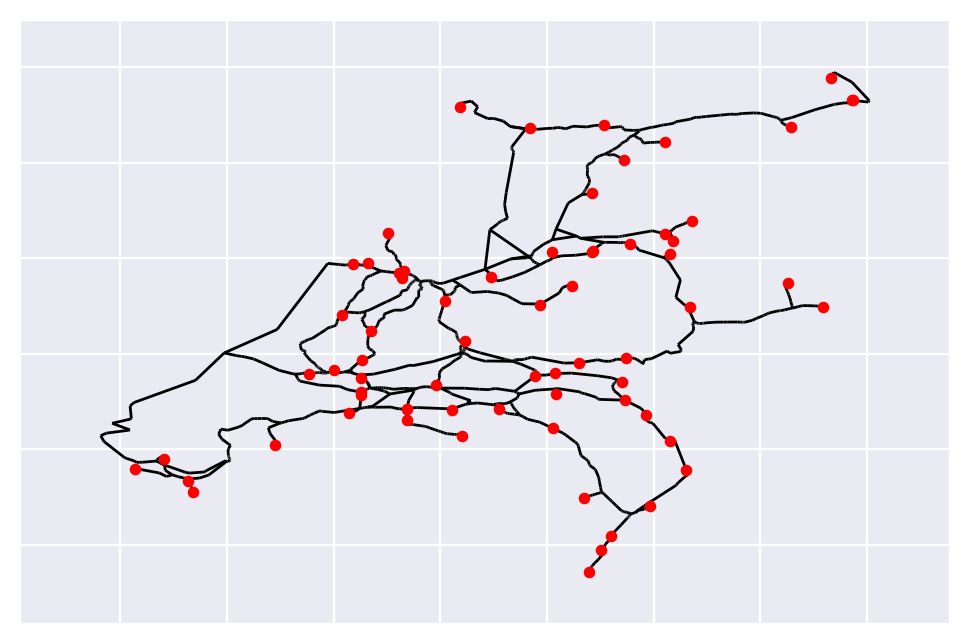

In [43]:
harbour_nodes = list(df_h.harbour_node.unique())
node_list = []
for key, route in routes_types_paths.items():
    node_list.append(route)

expanded_node_list = [x for xs in node_list for x in xs]
node_list = list(set(expanded_node_list))
G = G.subgraph(node_list)
G = nx.Graph(G)

plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_size=10, node_color='red')

In [26]:
### Remove 0 entries from all datasets
for i in df_ivs_exploded.index:
    if df_ivs_exploded.trip_count[i] == 0:
        try:
            del routes_types_paths[(df_ivs_exploded.origin[i],df_ivs_exploded.destination[i],df_ivs_exploded.route_v[i])]
            del routes_types_path_lengths[(df_ivs_exploded.origin[i],df_ivs_exploded.destination[i],df_ivs_exploded.route_v[i])]
        except:
            print("already gone")
        # try:
        #     df_ivs_exploded=df_ivs_exploded.drop(labels=[i], axis=0)
        # except:
        #     print("already gone")
        del routes_dests[(df_ivs_exploded.origin[i],df_ivs_exploded.destination[i],df_ivs_exploded.route_v[i])]

In [27]:
df_ivs_exploded.reset_index(inplace=True, drop=True)

In [47]:
routes_dests

{('NLRTM', 'NLAMS'): {0: ('I', 'II', 'III'),
  1: ('IV', 'V_A'),
  2: ('V_B', 'VI_B', 'VI_C', 'VI_A')},
 ('NLRTM', 'NLMOE'): {0: ('I', 'II', 'III', 'IV', 'V_A'),
  1: ('V_B', 'VI_B', 'VI_C', 'VI_A')},
 ('NLRTM',
  'NLVLI'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLAMS',
  'NLAER'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLVEG',
  'NLRTM'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLTLB', 'NLRTM'): {0: ('I',),
  1: ('VI_B', 'II', 'III', 'VI_A', 'V_B', 'IV', 'VI_C', 'V_A')},
 ('NLLEY',
  'NLAMS'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLOSS',
  'NLRTM'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NLZWO',
  'NLAMS'): {0: ['I',
   'II',
   'III',
   'IV',
   'V_A',
   'V_B',
   'VI_A',
   'VI_B',
   'VI_C']},
 ('NL

In [33]:
df_ivs_exploded.loc[df_ivs_exploded.hour==0]

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,B04,M0,C2l,BII-2L,B02,C1b,C2b,B01,C1l,route_v
0,NLRTM,NLAMS,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,NLRTM,NLAMS,171,0,0,109,0,0,2,45,...,0,0,0,0,0,0,0,0,0,1
48,NLRTM,NLAMS,152,0,91,0,0,18,0,0,...,0,0,0,1,0,0,0,0,0,2
72,NLRTM,NLMOE,63,0,0,48,0,0,0,9,...,0,0,0,0,0,0,0,0,0,0
96,NLRTM,NLMOE,34,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3792,NLAMS,NLZWI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3816,NLAMS,NLZWI,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3840,NLAMS,NLZWI,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3864,NLAMS,NLZWI,2,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


### Pickle all resulting files

In [48]:
#store graph
pickle.dump( G, open( "data/revised_cleaning_results/cleaned_network.p", "wb" ) )
# store found harbours inc. harbour nodes and loc
pickle.dump( df_h, open( "data/revised_cleaning_results/harbour_data_100.p", "wb" ) )
# store found ivs data by route
pickle.dump( df_ivs_exploded, open( "data/revised_cleaning_results/ivs_exploded_100.p", "wb" ) )
# store which ships use which routes
pickle.dump( routes_dests, open( "data/revised_cleaning_results/users_ship_specific_routes.p", "wb" ) )
# store the routes that these ships use
pickle.dump( routes_types_paths, open( "data/revised_cleaning_results/paths_ship_specific_routes.p", "wb" ) )
# store the lengths of these routes
pickle.dump( routes_types_path_lengths, open( "data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "wb" ) )

## Step 6: remove redundant intermediate nodes from dataset
This step is done in the network simplification notebook

# Code below was used to conclude that different routes had to be considered for OD pairs

### Q: how many links for large ships (e.g. not I, II or III) are not in the graph now?
Also plot links for small ships only in other color to visualise result

In [49]:
# # select nodes from org graph with not _0, I, II or III
# K = pickle.load(open('data/network_digital_twin_v0.3.pickle', 'rb'))
# df_links_or = nx.to_pandas_edgelist(K)
# df_nodes_or = pd.DataFrame.from_dict(dict(K.nodes(data=True)), orient='index')
#
# # bounding box nl
# bb = (3.31497114423, 50.803721015, 7.09205325687, 53.5104033474)
# df_nodes_or = df_nodes_or.loc[(df_nodes_or.X.between(bb[0], bb[2])) & (df_nodes_or.Y.between(bb[1], bb[3]))]
#
# #subset graph and make editable again
# K = K.subgraph(df_nodes_or.index)
# K = nx.Graph(K)
#
# df_links_or = nx.to_pandas_edgelist(K)
# df_nodes_or = pd.DataFrame.from_dict(dict(K.nodes(data=True)), orient='index')
#
# nx.draw_networkx_edges(K, pos_dict)

In [ ]:
# a = df_links_or.loc[~df_links_or.Code.isin(['_0','I','II','III'])]

In [ ]:
# large_edges_full = []
# for i in a.index:
#     large_edges_full.append(tuple([a.source[i], a.target[i]]))

In [ ]:
# len(large_edges_full)

In [ ]:
# large_edges = []
# large_links = df_links.loc[~df_links.Code.isin(['_0','I','II','III'])]
# for i in large_links.index:
#     large_edges.append(tuple([large_links.source[i], large_links.target[i]]))
#
# small_edges = []
# small_links = df_links.loc[df_links.Code.isin(['_0','I','II','III'])]
# for i in small_links.index:
#     small_edges.append(tuple([small_links.source[i], small_links.target[i]]))
#
# for node1, node2 in K.edges:
#     if node1 == node2:
#         print("Self loop identified node", node1)
#         K.remove_edge(node1,node2)
#
# df_links_or = nx.to_pandas_edgelist(K)
# df_nodes_or = pd.DataFrame.from_dict(dict(K.nodes(data=True)), orient='index')
# large_not_in_G = list(set(large_edges_full)-set(large_edges))

In [ ]:
# len(small_edges)

In [ ]:
# len(large_edges)
# # good, counts up till

In [ ]:
# fig, ax = plt.subplots(dpi=200)
# K = K.subgraph(large_not_in_G)
# K = nx.Graph(K)
#
# nx.draw_networkx_edges(G, pos_dict,large_edges, edge_color='g',ax=ax, label='large edges subset')
# nx.draw_networkx_edges(G, pos_dict, small_edges, edge_color='b',ax=ax, label='small edges subset')
# nx.draw_networkx_edges(G, pos_dict, large_not_in_G, edge_color='r',ax=ax, label='large not in subset')
# nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_size=10, node_color='y', label='harbours')
# plt.legend(fontsize=8)
# plt.show()
#

## Intermediate checks
1. Are all paths available of df_ivs?
2. Which paths are unavailable and is this supposed so?

# 1.

In [ ]:
# for i in df_ivs.index:
#     org = df_ivs.origin[i]
#     org = df_h.loc[df_h.harbour_code == org]['harbour_node'].values[0]
#     dest = df_ivs.destination[i]
#     dest = df_h.loc[df_h.harbour_code == dest]['harbour_node'].values[0]
#     try:
#         nx.dijkstra_path(G, org, dest, weight='length_m')
#     except:
#         print("Path between", dest, "and", org, "not feasible")

Looks okay, all path of df_ivs are available

In [ ]:
# types = list(df_links.Code.unique())
# types.remove('_0')
# types = sorted(types[1:])
# print(types)
# type_dict={}
# #minus 1 because last one is open class anyway
# for i in range(len(types)-1):
#     type_dict[i] = types[:(i+1)]
# type_dict[8]=types

In [ ]:
# type_dict

In [ ]:
# # code below was used to conclude that it was necessary to consider different routes for different ships.
# # does not work after network cleaning though, but principle of step 3 is the same

In [ ]:
# #To what extent to paths differ for these OD pairs for different boat types?
# for i in df_ivs.index:
#
#     org_n = df_ivs.origin[i]
#     org = df_h.loc[df_h.harbour_code == org_n]['harbour_node'].values[0]
#     dest_n = df_ivs.destination[i]
#     dest = df_h.loc[df_h.harbour_code == dest_n]['harbour_node'].values[0]
#
#     org_route = nx.dijkstra_path(G, org, dest, weight='length_m')
#     for type_index, types_exc in type_dict.items():
#
#         #copy graph
#         H = G.copy()
#
#         #determine links that are available based on dict (e.g. not of the type in type_exc list)
#         unavailable_edges = df_links.loc[df_links.Code.isin(types_exc)]
#         #now remove those edges
#         for link in unavailable_edges.index:
#             H.remove_edge(unavailable_edges.source[link], unavailable_edges.target[link])
#
#         if nx.has_path(H, org, dest):
#             route_type = nx.dijkstra_path(H, org, dest, weight='length_m')
#             if route_type != org_route:
#                 print("Ships of type", set(types)-set(types_exc), "must take other route for path", org_n, dest_n)
#                 org_route = route_type
#         else:
#             print("Path between", org_n, "and", dest_n, "not feasible for types", set(types)-set(types_exc))
#             break

Based on these observations, step 3: flow splitting was inserted above